## Set Up Hugging Face Space Environment

In [ ]:
!pip install huggingface_hub

from huggingface_hub import login

login(token="")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## What are the training types of each encoder and decoder models?
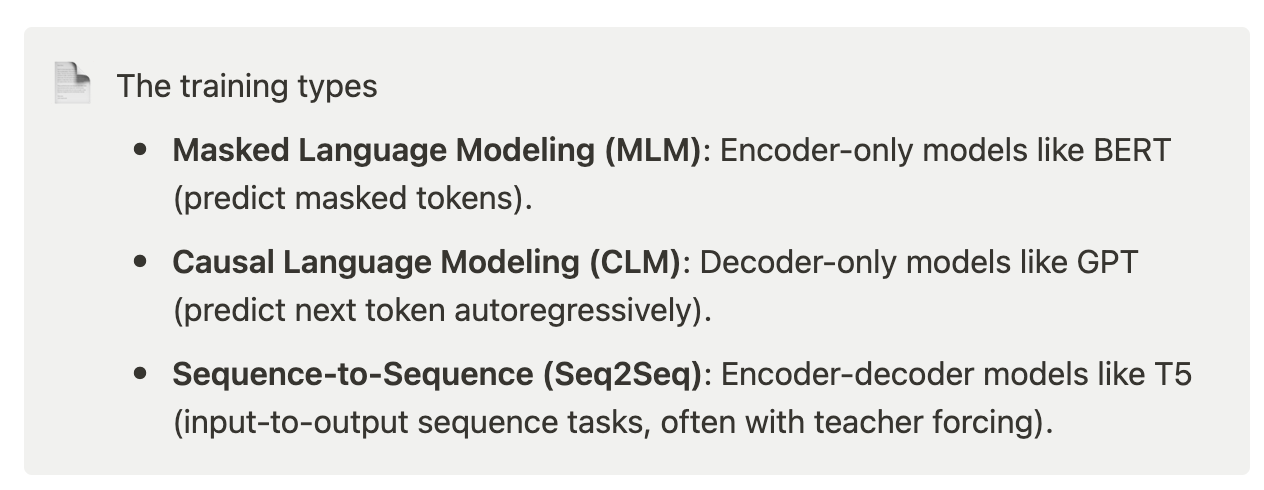

* Teacher Forcing: During training, the model is fed the true output (the target sequence) at each time step instead of using its own predictions from the previous time step.
* T5: A model that treats all NLP tasks as text-to-text problems, meaning both the inputs and outputs are in text format.

### Full Transformer


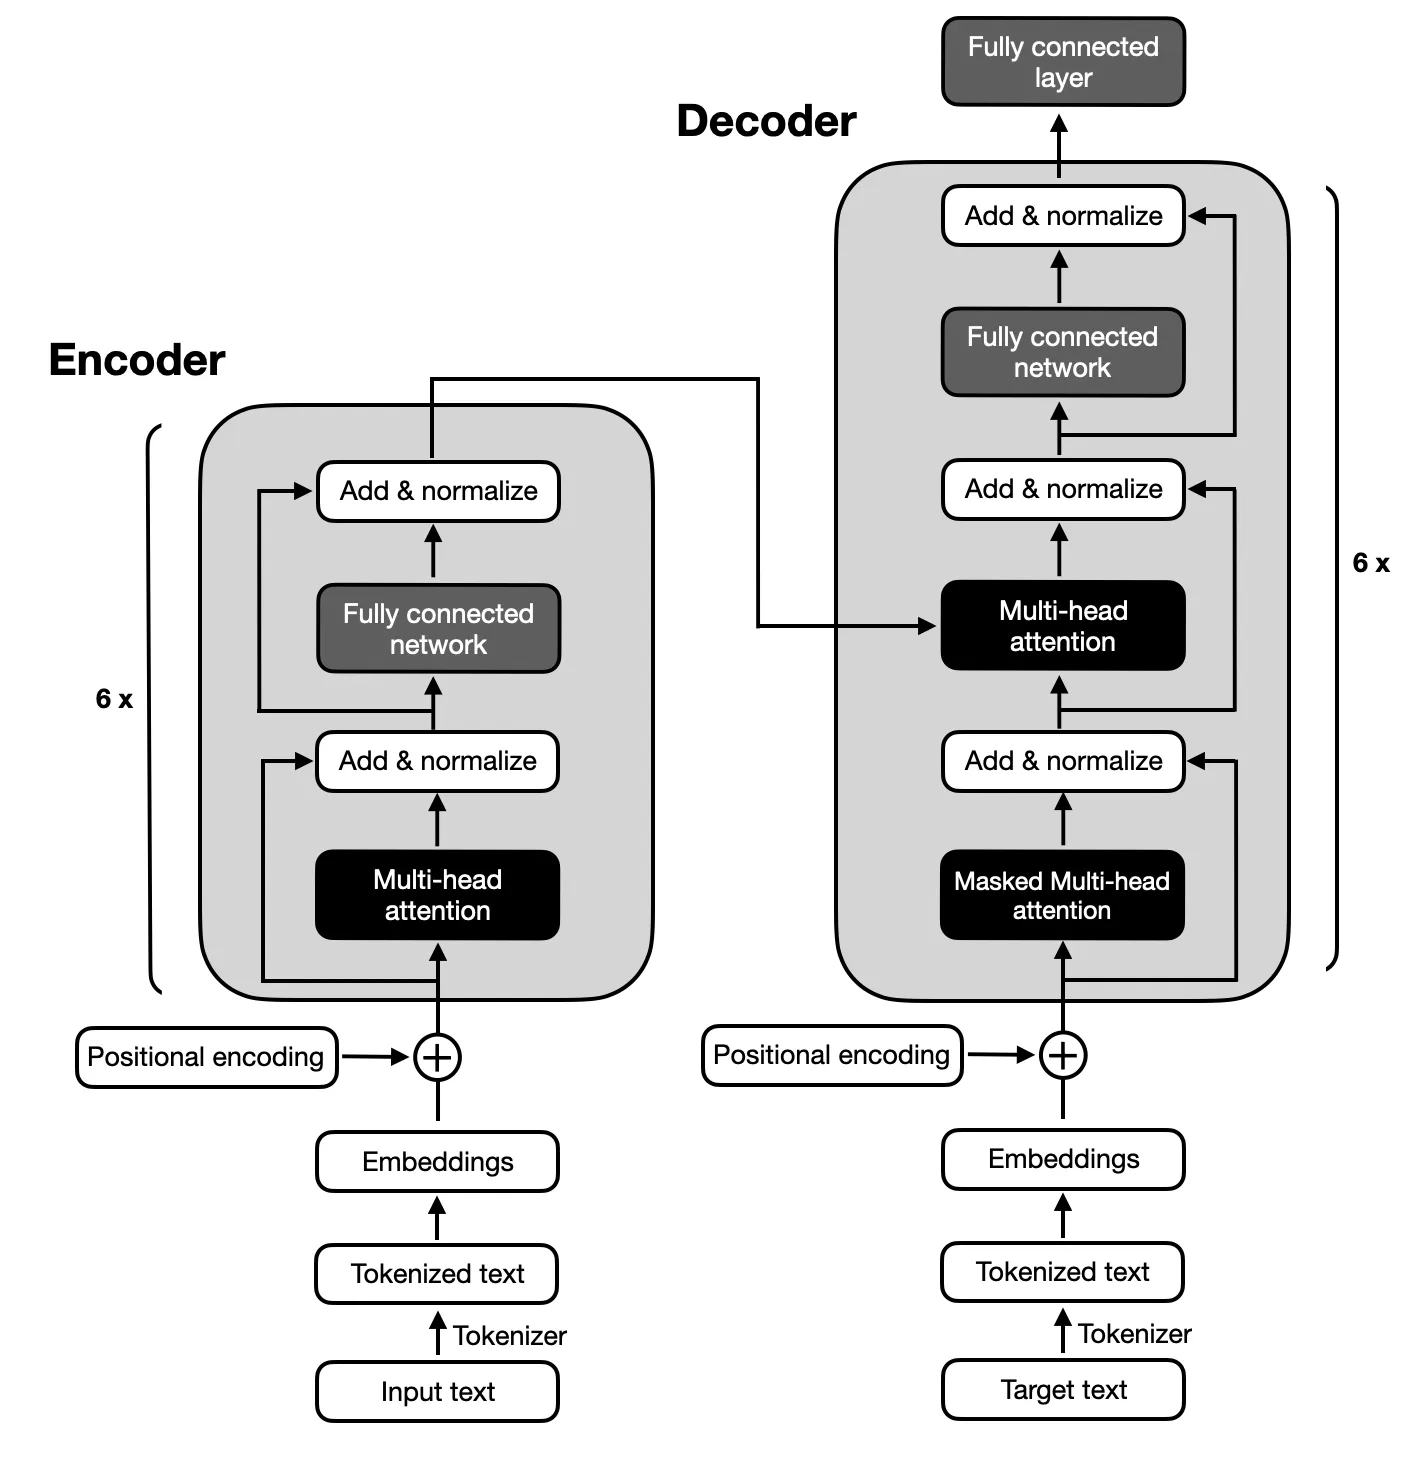

**1 Input Test**: Define a text that is to be translated.

In [ ]:
input_text = "Hello, how are you?"

**2 Tokenization**: Tokenize the input text into individual word tokens using tokenizer


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = tokenizer.encode(input_text, return_tensors='pt')
print(f"Input IDs: {input_ids}")
print(f"Shape: {input_ids.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Input IDs: tensor([[ 101, 7592, 1010, 2129, 2024, 2017, 1029,  102]])
Shape: torch.Size([1, 8])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


- 1: batch size
- 8: # of tokens

**3 Embedding Layer**: Convert token ids into embedding vector, which converts categorical input data, like words or items, into dense vector representations, capturing semantic relationships in a continuous space.


In [ ]:
import torch
from transformers import BertModel

model = BertModel.from_pretrained('bert-base-uncased')
embeddings = model.embeddings(input_ids)
print(f"Shape: {embeddings.shape}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Shape: torch.Size([1, 8, 768])


- 1: batch size
- 8: # of tokens
- 768 (fixed): an embedding dimension of each token (12 transformer layers)

In [ ]:
embeddings

tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [ 3.7386e-01, -1.5575e-02, -2.4561e-01,  ..., -3.1657e-02,
           5.5144e-01, -5.2406e-01],
         [ 4.6705e-04,  1.6225e-01, -6.4443e-02,  ...,  4.9443e-01,
           6.9413e-01,  3.6286e-01],
         ...,
         [-4.7605e-01,  1.5526e-01,  5.0374e-01,  ...,  4.7703e-01,
           5.4990e-01,  4.3808e-01],
         [ 6.0006e-01, -4.1418e-01, -5.4667e-01,  ...,  1.4079e-01,
           6.7320e-01,  5.7844e-01],
         [-2.5515e-01, -2.6706e-01,  7.9946e-02,  ..., -4.2870e-01,
           3.4145e-01, -1.0551e-01]]], grad_fn=<NativeLayerNormBackward0>)

**4 Positional Encoding**: Add a positional encoding vector to each embedded word
- Positional encoding is a method used in Transformer models to represent the order of input tokens. Since the model processes all tokens simultaneously and doesn't inherently understand their sequence, positional encoding adds information to indicate where each token is located.

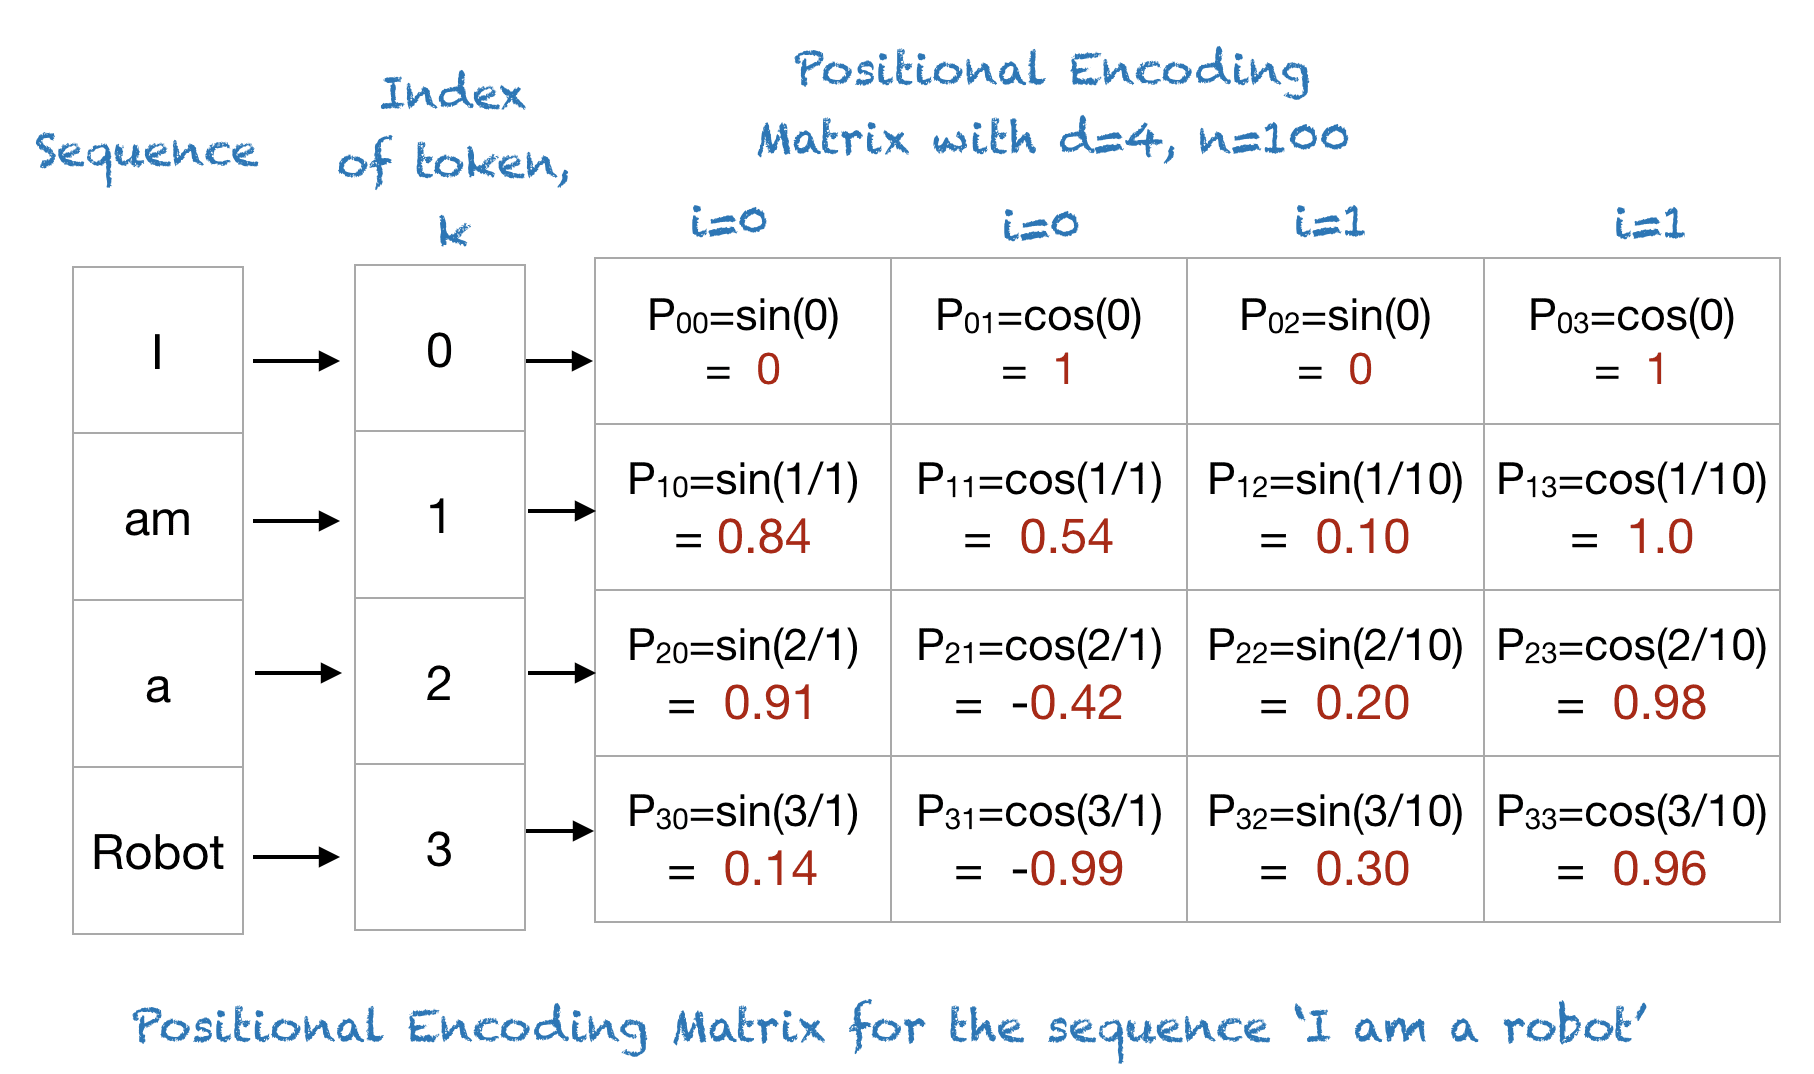

In [ ]:
class PositionalEncoding(torch.nn.Module):
  def __init__(self, d_model, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.encoding = torch.zeros(max_len, d_model)
    print(f"self.encoding shape: {self.encoding.shape}")
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
    self.encoding[:, 0::2] = torch.sin(position * div_term)
    self.encoding[:, 1::2] = torch.cos(position * div_term)
    self.encoding = self.encoding.unsqueeze(0)

  def forward(self, x):
    return x + self.encoding[:, :x.size(1)]

position_encoding = PositionalEncoding(768)
embeddings = position_encoding(embeddings)
print(f"embeddings: {embeddings}")
print(f"Shape: {embeddings.shape}")

self.encoding shape: torch.Size([5000, 768])
embeddings: tensor([[[ 0.1686,  0.7142, -0.3261,  ...,  0.9724,  0.0383,  1.1640],
         [ 1.2153,  0.5247,  0.5828,  ...,  0.9683,  0.5515,  0.4759],
         [ 0.9098, -0.2539,  0.8636,  ...,  1.4944,  0.6943,  1.3629],
         ...,
         [-1.4350,  0.4389, -0.4820,  ...,  1.4770,  0.5504,  1.4381],
         [ 0.3206,  0.5460, -0.9593,  ...,  1.1408,  0.6738,  1.5784],
         [ 0.4018,  0.4868,  0.6034,  ...,  0.5713,  0.3422,  0.8945]]],
       grad_fn=<AddBackward0>)
Shape: torch.Size([1, 8, 768])


1. `self.encoding, torch.Size([5000, 768])`
  - 5000: Represents the maximum sequence length, allowing for positional encodings for up to 5000 tokens.
  - 768: Corresponds to the embedding dimension, meaning each position in the sequence has a 768-dimensional encoding.

2. `embeddings, torch.Size([1, 8, 768])`
  - 1: Batch size, indicating one set of input data is being processed.
  - 8: Sequence length, meaning there are eight tokens (or words) in the input sequence.
  768: Embedding dimension, representing each token as a vector of 768 values.


**[Encoder]** <br>
**5 Multi-Head Self-Attention**: Apply a multi-head self-attention layer to the embedding, applying multiple attention mechanisms in parallel to the embedded input, allowing the model to capture diverse relationships and dependencies between tokens simultaneously.

https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html


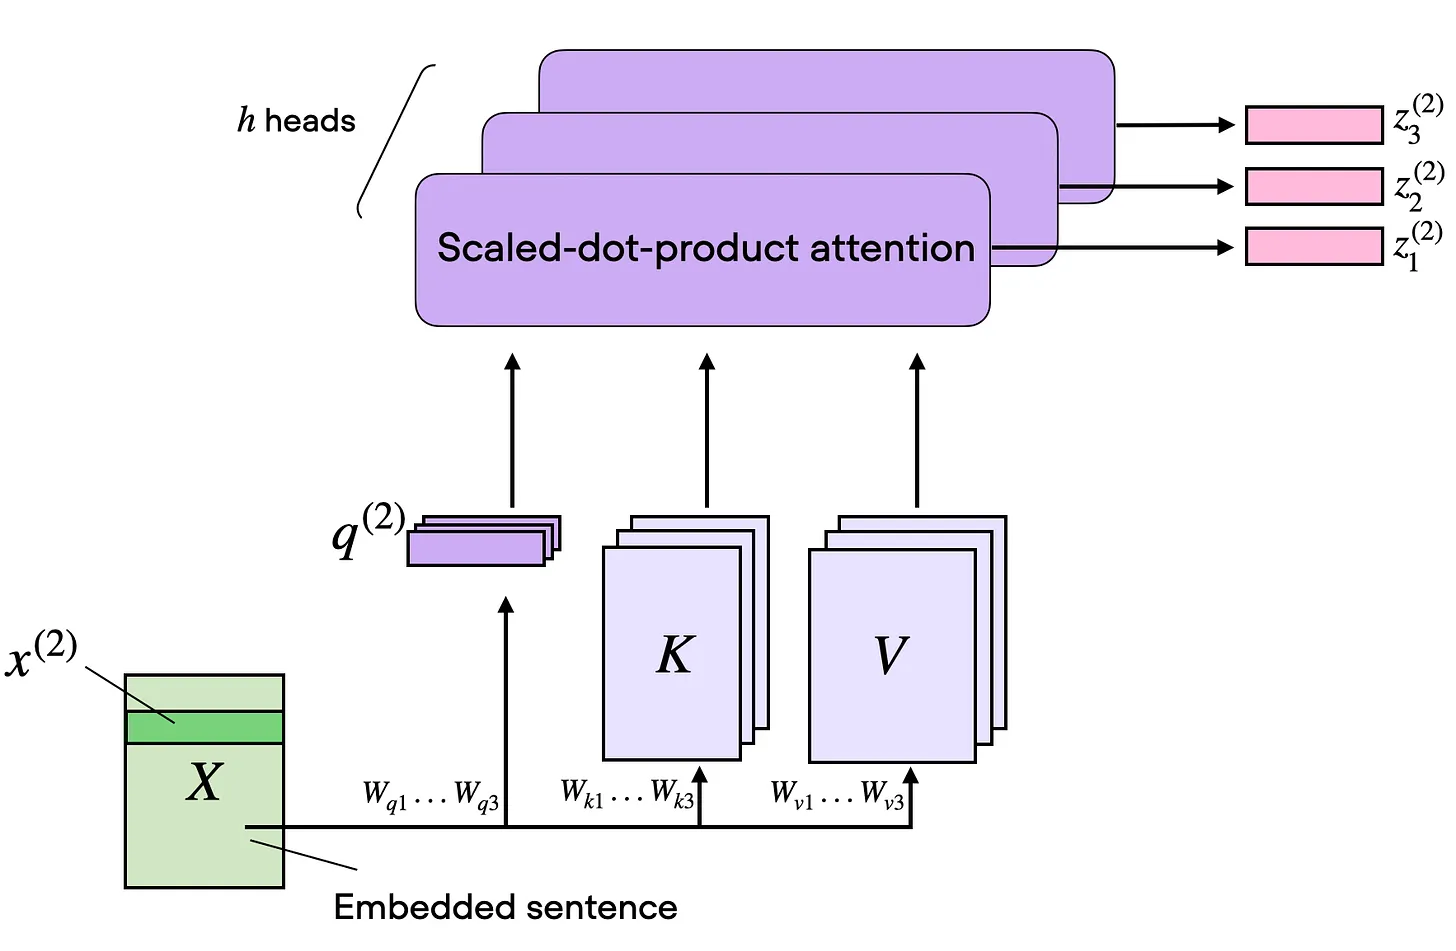

In [ ]:
from torch.nn import MultiheadAttention

self_attention = MultiheadAttention(embed_dim=768, num_heads=8)
atten_output, atten_weights = self_attention(embeddings.transpose(0, 1), embeddings.transpose(0, 1), embeddings.transpose(0, 1))
atten_output = atten_output.transpose(0, 1)
print(f"atten_weights: {atten_weights}")
print(f"Shape of atten_output {atten_output.shape}")
print("\n")
print(f"atten_weights: {atten_weights}")
print(f"Shape of atten_weights {atten_weights.shape}")

atten_weights: tensor([[[0.1285, 0.1225, 0.1244, 0.1407, 0.1176, 0.1173, 0.1273, 0.1217],
         [0.1433, 0.1281, 0.1236, 0.1522, 0.1216, 0.1088, 0.1127, 0.1097],
         [0.1250, 0.1211, 0.1104, 0.1474, 0.1172, 0.1252, 0.1345, 0.1192],
         [0.1194, 0.1266, 0.1212, 0.1568, 0.1192, 0.1164, 0.1253, 0.1150],
         [0.1180, 0.1148, 0.1293, 0.1403, 0.1232, 0.1193, 0.1389, 0.1163],
         [0.1226, 0.1315, 0.1256, 0.1379, 0.1225, 0.1089, 0.1342, 0.1169],
         [0.1147, 0.1233, 0.1215, 0.1479, 0.1240, 0.1192, 0.1321, 0.1173],
         [0.1316, 0.1188, 0.1299, 0.1319, 0.1290, 0.1126, 0.1251, 0.1211]]],
       grad_fn=<MeanBackward1>)
Shape of atten_output torch.Size([1, 8, 768])


atten_weights: tensor([[[0.1285, 0.1225, 0.1244, 0.1407, 0.1176, 0.1173, 0.1273, 0.1217],
         [0.1433, 0.1281, 0.1236, 0.1522, 0.1216, 0.1088, 0.1127, 0.1097],
         [0.1250, 0.1211, 0.1104, 0.1474, 0.1172, 0.1252, 0.1345, 0.1192],
         [0.1194, 0.1266, 0.1212, 0.1568, 0.1192, 0.1164, 0.125

1. `atten_output, shape torch.Size([1, 8, 768])`
  - 1: Batch size, meaning one set of input data is being processed.
  - 8: Sequence length, indicating eight tokens (or words) in the input sequence.
  - 768: Embedding dimension, meaning each token is represented by a vector of 768 values.

2. `atten_weights, shape torch.Size([1, 8, 8])`
  - 1: Batch size, indicating one set of input data.
  - 8: First dimension of eight corresponds to the sequence length, representing each of the eight tokens.
  - 8: Second dimension of eight also corresponds to the sequence length, showing how each of the eight tokens attends to the other eight tokens.

**6 Add & Normalize**: Conduct layer normalization and add the original embeddings via a skip connection (residual connection), preventing from vanishing gradients.

In [ ]:
from torch.nn import LayerNorm

norm = LayerNorm(768)
output_norm = norm(atten_output + embeddings)
print(f"output_norm: {output_norm}")
print(f"Shape of output_norm {output_norm.shape}")

output_norm: tensor([[[-0.2863,  0.7805, -1.1575,  ...,  0.7927,  0.0117,  0.9280],
         [ 0.9106,  0.4595, -0.0812,  ...,  0.7096,  0.5376,  0.0284],
         [ 0.5165, -0.6124,  0.2041,  ...,  1.4307,  0.7464,  1.1411],
         ...,
         [-2.2659,  0.4524, -1.3047,  ...,  1.3964,  0.6420,  1.2725],
         [-0.0712,  0.5807, -1.8526,  ...,  0.9891,  0.8364,  1.4776],
         [ 0.0559,  0.5608,  0.0529,  ...,  0.3079,  0.4534,  0.6434]]],
       grad_fn=<NativeLayerNormBackward0>)
Shape of output_norm torch.Size([1, 8, 768])


- 1: Batch size, indicating one set of input data is being processed.
- 8: Sequence length, meaning there are eight tokens (or words) in the input sequence.
- 768: Embedding dimension, representing each token as a vector of 768 values.

**7 Fully Connected Layer**: Pass the embeddings through a fully connected layer, which is MLP (a small multilayer perceptron with two fully connected layers and a nonlinear activation function in between.), used to capture complex patterns and interactions in the data.

In [ ]:
full_layer = torch.nn.Sequential(
    torch.nn.Linear(768, 3072),
    torch.nn.ReLU(),
    torch.nn.Linear(3072, 768)
)
output_reshaped = output_norm.view(-1, 768)

full_output = full_layer(output_reshaped)
print(f"full_output: {full_output}")
print(f"Shape of full_output: {full_output.shape}")

full_output: tensor([[-0.0833, -0.3197,  0.1886,  ...,  0.3200, -0.0563,  0.2564],
        [-0.2188, -0.2734, -0.0087,  ...,  0.0931, -0.0318,  0.1003],
        [ 0.1223, -0.3317,  0.1837,  ..., -0.0875,  0.0041,  0.2319],
        ...,
        [-0.0922, -0.1102, -0.0326,  ..., -0.1506,  0.0704,  0.0275],
        [-0.1099, -0.4190,  0.2296,  ...,  0.0232,  0.1261,  0.2925],
        [-0.2275, -0.4788,  0.4026,  ...,  0.3360,  0.2750, -0.0317]],
       grad_fn=<AddmmBackward0>)
Shape of full_output: torch.Size([8, 768])


- 8: Sequence length, indicating there are eight tokens (or words) in the input sequence. Each row corresponds to the output representation of one token.
- 768: Embedding dimension, meaning each token is represented as a vector of 768 values.


**8 Add & Normalize (Post-Fully Connected)**: Add and normalize the output again.

In [ ]:
output_norm = norm(full_output + output_norm)
print(f"output_norm: {output_norm}")
print(f"Shape of output_norm {output_norm.shape}")

output_norm: tensor([[[-0.3502,  0.4571, -0.9328,  ...,  1.0908, -0.0343,  1.1604],
         [ 0.6909,  0.2019, -0.0650,  ...,  0.7981,  0.5111,  0.1464],
         [ 0.6432, -0.8948,  0.3993,  ...,  1.3277,  0.7518,  1.3567],
         ...,
         [-2.2539,  0.3421, -1.2725,  ...,  1.2106,  0.6979,  1.2628],
         [-0.1664,  0.1649, -1.5599,  ...,  0.9870,  0.9388,  1.7193],
         [-0.1550,  0.0902,  0.4515,  ...,  0.6338,  0.7155,  0.6026]]],
       grad_fn=<NativeLayerNormBackward0>)
Shape of output_norm torch.Size([1, 8, 768])


- 1: (Added) The batch size indicates that you are processing one set of data.
- 8: The sequence length shows that there are eight tokens.
- 768: The embedding dimension confirms that each token representation has 768 values.


**[Decoder]** <br>
**9 Multi-Head Self-Attention**: Pass the output to a multi-head attention layer of the decoder part.


In [ ]:
decoder_attn_output, _ = self_attention(output_norm.transpose(0, 1), output_norm.transpose(0, 1), output_norm.transpose(0, 1))
decoder_attn_output = decoder_attn_output.transpose(0, 1)
print(f"decoder_attn_output: {decoder_attn_output}")
print(f"Shape of decoder_attn_output {decoder_attn_output.shape}")

decoder_attn_output: tensor([[[ 0.2466,  0.5790,  0.1000,  ...,  0.2887,  0.3409, -0.2473],
         [ 0.2216,  0.5827,  0.1007,  ...,  0.2897,  0.2628, -0.2157],
         [ 0.2190,  0.5728,  0.1134,  ...,  0.3175,  0.3261, -0.2114],
         ...,
         [ 0.2272,  0.6294,  0.1391,  ...,  0.2923,  0.3156, -0.2033],
         [ 0.2439,  0.5999,  0.1526,  ...,  0.2695,  0.3292, -0.1966],
         [ 0.2651,  0.5986,  0.1345,  ...,  0.2639,  0.3417, -0.2522]]],
       grad_fn=<TransposeBackward0>)
Shape of decoder_attn_output torch.Size([1, 8, 768])


- 1: Batch size, indicating that one set of input data is being processed.
- 8: Sequence length, meaning there are eight tokens (or words) in the input sequence.
- 768: Embedding dimension, representing each token as a vector of 768 values.

**10 Output Text**: Print the final output text

In [ ]:
output_logits = torch.nn.Linear(768, tokenizer.vocab_size)(decoder_attn_output)
output_probs = torch.softmax(output_logits, dim=-1)
print(f"output_logits: {output_logits}")
print(f"Shape of output_logits {output_logits.shape}")
print("\n")
print(f"output_probs: {output_probs}")
print(f"Shape of output_probs {output_probs.shape}")

output_logits: tensor([[[ 0.3343,  0.1491,  0.1379,  ...,  0.0585, -0.0306, -0.2855],
         [ 0.3582,  0.1400,  0.1317,  ...,  0.0545, -0.0123, -0.2689],
         [ 0.3229,  0.1575,  0.1431,  ...,  0.0609, -0.0392, -0.2693],
         ...,
         [ 0.3398,  0.1620,  0.1473,  ...,  0.0771, -0.0154, -0.2769],
         [ 0.3634,  0.1374,  0.1472,  ...,  0.0634, -0.0340, -0.2625],
         [ 0.3606,  0.1362,  0.1680,  ...,  0.0767, -0.0338, -0.3008]]],
       grad_fn=<ViewBackward0>)
Shape of output_logits torch.Size([1, 8, 30522])


output_probs: tensor([[[4.5060e-05, 3.7443e-05, 3.7025e-05,  ..., 3.4200e-05,
          3.1284e-05, 2.4245e-05],
         [4.6163e-05, 3.7115e-05, 3.6805e-05,  ..., 3.4073e-05,
          3.1871e-05, 2.4657e-05],
         [4.4555e-05, 3.7762e-05, 3.7222e-05,  ..., 3.4285e-05,
          3.1021e-05, 2.4643e-05],
         ...,
         [4.5315e-05, 3.7932e-05, 3.7380e-05,  ..., 3.4843e-05,
          3.1766e-05, 2.4457e-05],
         [4.6400e-05, 3.7013e-05, 3.

1. `output_logits, torch.Size([1, 8, 30522])`
  - 1: Batch size, indicating that one set of input data is being processed.
  - 8: Sequence length, meaning there are eight tokens (or words) in the input sequence.
  - 30522: This represents the vocabulary size, indicating that for each of the eight tokens, the model outputs a logit for each of the 30,522 possible words in the vocabulary.

2. `output_probs, torch.Size([1, 8, 30522])`
  - 1: Batch size, same as above.
  - 8: Sequence length, again indicating eight tokens in the input.
  - 30522: Vocabulary size, consistent with the logits, representing the probability of each token corresponding to each word in the vocabulary.


## What are the new features of llama over other vanilla GenAI?

1. Model Size: 405 billion parameters.
2. Multi-Language Support: Capable of processing text in eight languages.
3. Up-to-Date Learning: Trained on data available up to 2024.
4. Extended Context Length: Supports context lengths of up to 128 tokens.
5. Faster Response Time: Responds to queries 35% faster.
6. Fine-Tuned for Zero-Shot Tool Use: Enhanced capabilities for zero-shot applications.
7. Model Distillation: Transfers knowledge and emergent abilities from the 405B model to smaller, more efficient variants.
8. Automated Program Development: Enables the creation of automated agents and enhances security features.


https://www.amitysolutions.com/blog/llama-3-1-meta-ai-features <br>
https://builtin.com/articles/llama-3.1

## LoRA


A technique, which stands for *Low-Rank Adaptation of Large Language Models*, which reduces the number of trainable parameters
- by inserting a smaller number of new weights into the model and only these are trained
- by learning pairs of rank-decomposition matrices while freezing the original weights.

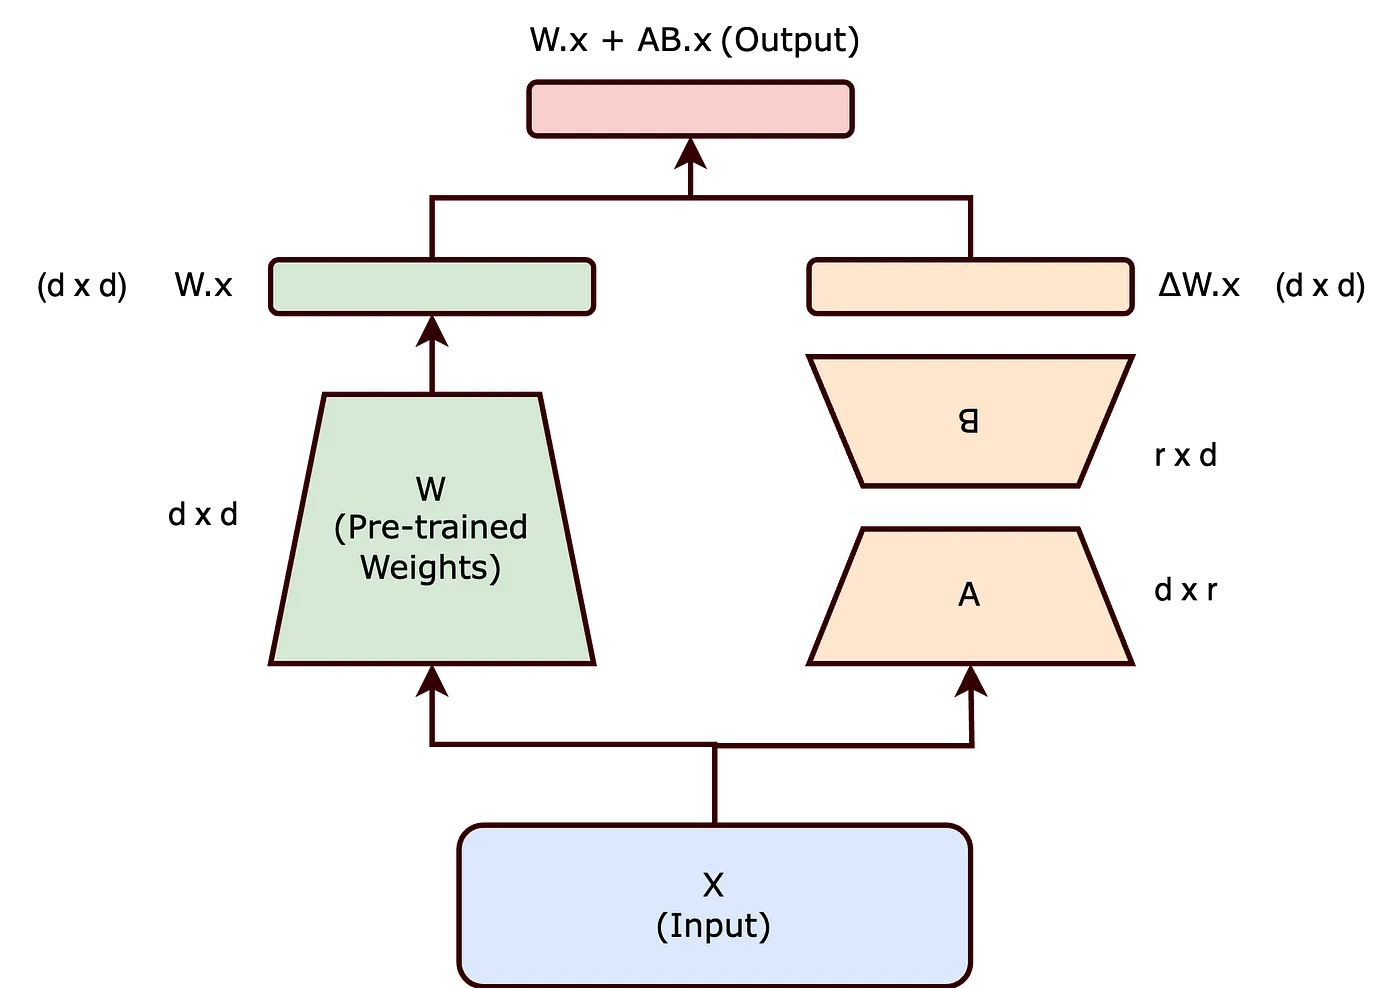

- Traditional Fine-tuning: Modify a pre-trained neural network's weights to adapt to a new task.
  1. Update $W$ would involve $d^2$ parameters.
- LoRA
  1. Intrinsic Rank Hypothesis: Significant changes to the neural network can be captured using a lower-dimensional representation.
  2. $Δ W$ > $A$, $B$ with a lower rank.
  3. Update $W' = W+BA$, $W$ remains frozen
  4. $BA = (d \space x \space r) * (r\space x \space d) = 2dr$

https://github.com/microsoft/LoRA <br>
https://huggingface.co/docs/diffusers/en/training/lora <br>
https://towardsdatascience.com/understanding-lora-low-rank-adaptation-for-finetuning-large-models-936bce1a07c6 <br>

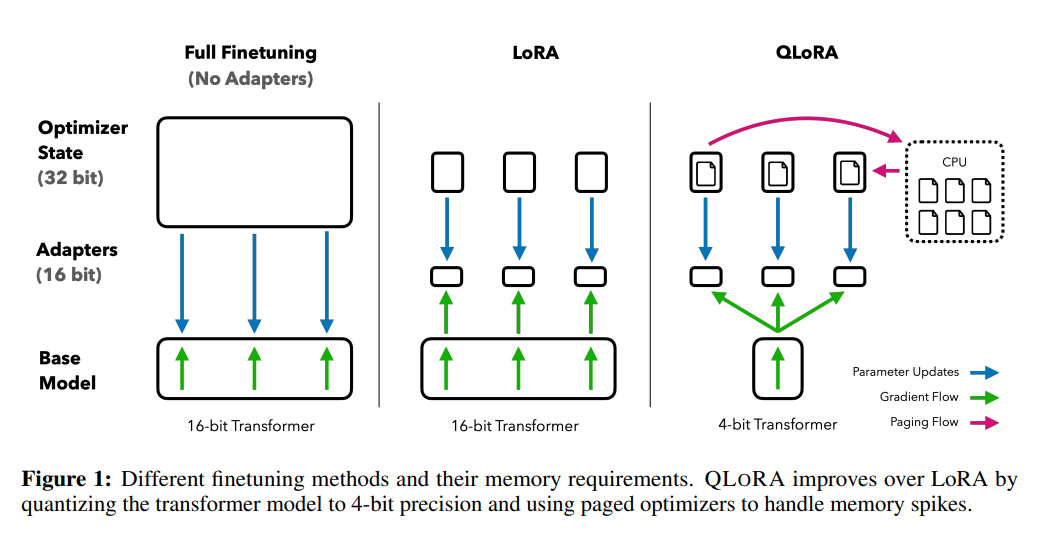

### What are the variants of LLM?

**Auto Classes** <br>
Automatically retrieve the relevant model given the name/path to the pretrained weights/config/vocabulary.

- `AutoConfig`: A generic configuration class that will be instantiated as one of the configuration classes of the library.
- `AutoModel`: A generic model class that will be instantiated as one of the base model classes of the library.
  - `AutoModelForCausalLM`: A generic model class that will be instantiated as one of the model classes of the library with a causal language modeling head. (Predicts the next token in a sequence based on the previous tokens **for generating text**.)
- `AutoTokenizer`: A generic tokenizer class that will be instantiated as one of the tokenizer classes of the library.
  - `input_id`: numerical representations of your tokens.
  - `attention_mask`: indicates which tokens should be attended to.



**PEFT Classes** <br>
Designed for efficient fine-tuning of pretrained models, especially when using parameter-efficient tuning methods like LoRA.
- `LoraConfig`: A configuration class specifically for setting up LoRA parameters, allowing you to customize how the model adapts to new tasks while maintaining efficiency in resource usage.
  - `r=8`: Specifies the rank of low-rank matrices, allowing for efficient adaptation with 8-dimensional projections.

  - `lora_alpha=32`: A scaling factor for low-rank updates, enhancing their influence on model predictions.

  - `lora_dropout=0.1`: Sets a 10% dropout rate to prevent overfitting by randomly zeroing some updates during training.

  - `target_modules=["q_proj", "v_proj"]`: Indicates which model components (query and value projections) will be fine-tuned using LoRA.
- `get_peft_model`: A utility function that retrieves a parameter-efficient fine-tuning model based on the given pretrained model and LoRA configuration.

In [ ]:
from peft import get_peft_model, LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
)

model = get_peft_model(model, lora_config)

print(model)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

PeftModel(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_features=20

**PeftModel** <br>

- `base_model` (LoraModel): A model that incorporates LoRA (Low-Rank Adaptation) for efficient tuning.
- `model (LlamaForCausalLM)`: Fine-tuned specific language model designed for causal language modeling.
- `LlamaModel`: The core architecture of the Llama model, which includes:
  - `embed_tokens`: Token embeddings, mapping input tokens to a higher-dimensional space.
  - `layers`: A list of 16 transformer layers (LlamaDecoderLayer) that process the input through self-attention and feed-forward networks.
    - `self_attn`: Mechanism for the model to focus on different parts of the input sequence:
      - `q_proj` and `v_proj`: Linear layers with LoRA adaptations for query and value projections, including dropout and low-rank components.
      - `k_proj`: A linear layer for key projections without LoRA.
      - `o_proj`: An output projection layer.
      - `rotary_emb`: Rotary embeddings for enhanced positional encoding.
    - `mlp`: Multi-Layer Perceptron (MLP) that processes outputs from the self-attention layers.
  - `norm`: Layer normalization applied to stabilize training.
  - `lm_head`: Linear layer that predicts the output token probabilities based on the final hidden states.

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

base_model.model.model.embed_tokens.weight: torch.Size([128256, 2048])
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight: torch.Size([2048, 2048])
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: torch.Size([2048, 8])
base_model.model.model.layers.0.self_attn.k_proj.weight: torch.Size([512, 2048])
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight: torch.Size([512, 2048])
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: torch.Size([512, 8])
base_model.model.model.layers.0.self_attn.o_proj.weight: torch.Size([2048, 2048])
base_model.model.model.layers.0.mlp.gate_proj.weight: torch.Size([8192, 2048])
base_model.model.model.layers.0.mlp.up_proj.weight: torch.Size([8192, 2048])
base_model.model.model.layers.0.mlp.down_proj.weig

**Model Overview**

Input Shape
- Input: `[batch_size, sequence_length, 2048]` (through embedding)

Embedding Layer
- Converts input tokens into high-dimensional vectors.
- Shape: `[128256, 2048]` (vocabulary size x embedding dimension)

Self-Attention Layers
- Composed of multiple layers, each processing input data.
- Each layer includes:
  - Query (q_proj):
    - Base Layer: `[2048, 2048]`
    - LoRA A: `[8, 2048]`
    - LoRA B: `[2048, 8]`
  - Key (k_proj):
    - Shape: `[512, 2048]`
  - Value (v_proj):
    - Base Layer: `[512, 2048]`
    - LoRA A: `[8, 2048]`
    - LoRA B: `[512, 8]`
  - Output Projection (o_proj):
    - Shape: `[2048, 2048]`
- Each self-attention layer maintains the shape of inputs and outputs, typically as `[batch_size, sequence_length, 2048]`.

MLP (Multi-Layer Perceptron)
- Applies additional nonlinear transformations based on the attention results.
- Components include:
  - Gate Projection: `[8192, 2048]`
  - Up Projection: `[8192, 2048]`
  - Down Projection: `[2048, 8192]`
- The MLP generally maintains the dimensionality, changing only through the intermediate projections.

Layer Normalization
- Normalizes outputs from each layer to stabilize training.
- Shape: `[2048]` for each normalization layer.

Output Layer
- Generates the final predictions.
- Shape: `[2048, 128256]` (for logits corresponding to the vocabulary size).


In [ ]:
# inputs = tokenizer("What is the capital of France?", return_tensors="pt")
# outputs = model.generate(inputs["input_ids"])

# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


What is the capital of France? A. Montpelier B. Boston C. Atlanta D


Fine-tune the model

In [ ]:
from datasets import Dataset

def preprocess_function(examples):
    inputs = tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = inputs["input_ids"].copy()
    return inputs

dataset = Dataset.from_pandas(df[:1000])
tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print(tokenized_datasets[0])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'input_ids': tensor([128000,   3696,     13,   6761,   7881,   6209,   4395,    602,   1427,
           369,    304,    264,   4689,  55472,     13,    220,    568,    596,
          6555,    323,   4228,    311,   3137,    311,   2085,   1694,  36380,
          4954,     26,    568,    596,   2744,    389,    892,    304,   9298,
           813,   6978,     26,    568,    596,  37506,    449,    264,   1948,
         78611,   8952,    320,   3919,     84,      8,    902,    856,   6699,
           617,  11497,    311,    757,    374,   1633,   3062,    304,   1162,
          2555,   8741,    323,    499,   1205,  15173,     26,    323,    499,
           649,    636,  70401,    311,   1518,  35416,   2085,   3515,    311,
          1518,   1461,   1176,     13,    220,   2216,     11,   1148,    810,
           656,    499,   1205,     30,    220,    602,   2846,  11961,   1618,
          4560,    311,   1781,    315,    904,  21859,    602,    617,    922,
          1461,     11,   

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none",
)

- `num_train_epochs=3`: Train the model for 3 full passes over the dataset.
- `per_device_train_batch_size=8`: Use a batch size of 8 samples for training per device.
- `per_device_eval_batch_size=16`: Use a batch size of 16 samples for evaluation per device.
- `warmup_steps=500`: Gradually increase the learning rate for the first 500 steps.
- `weight_decay=0.01`: Apply a 1% penalty to weights to reduce overfitting.

In [ ]:
train_dataset = tokenized_datasets.select(range(700))
eval_dataset = tokenized_datasets.select(range(700, 999))

print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 700
})
Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 299
})


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()

Create a chatbot interface

In [ ]:
import torch

def chat_with_bot():
    print("Chatbot")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    while True:
        user_input = input("User:")
        if user_input.lower() == 'end':
            print("Ending the conversation.")
            break

        inputs = tokenizer(user_input, return_tensors="pt").to(device)

        outputs = model.generate(inputs['input_ids'], max_length=150, do_sample=True, top_k=50, pad_token_id=tokenizer.eos_token_id)

        bot_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print("Chatbot: ", bot_response)

chat_with_bot()